In [1]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import norm
from scipy.stats import t as t_dist
import numpy as np
from scipy.stats import ttest_ind
from copy import deepcopy
import statsmodels.api as sm
import numpy as np

In [2]:
raw_data = pd.read_csv('criteo-uplift-v2.1.csv')

In [3]:
features = [f'f{i}' for i in range(12)]
feature_data = raw_data[features].copy()
feature_data = np.array(feature_data)

In [4]:
median  = np.median(feature_data[:,0])
list_1 = list(np.where(feature_data[:,0] > median)[0])
list_2 = list(np.where(feature_data[:,0] <= median)[0])

In [5]:
binary_groups = np.zeros((feature_data.shape[0],feature_data.shape[1]))
for j in range(feature_data.shape[1]):
    median  = np.median(feature_data[:,j])
    list_1 = list(np.where(feature_data[:,j] > median)[0])
    list_2 = list(np.where(feature_data[:,j] < median)[0])
    list_3 = list(np.where(feature_data[:,j] == median)[0])
    if len(list_3) != 0:
        sum_1 = len(list_1)
        sum_2 = len(list_2)
        if sum_1 > sum_2:
            a = sum_1 - sum_2
            # 生成随机排列，然后切分
            perm = np.random.permutation(list_3)
            split_idx = int((len(list_3) + a) / 2)

            list_temp1 = perm[:split_idx]  # 选前一半
            list_temp2 = perm[split_idx:]  # 剩下的一半

            # 直接扩展 list_2 和 list_1
            list_2.extend(list_temp1)
            list_1.extend(list_temp2)
        else:
            a = sum_2 - sum_1
            # 生成随机排列，然后切分
            perm = np.random.permutation(list_3)
            split_idx = int((len(list_3) + a) / 2)

            list_temp1 = perm[:split_idx]  # 选前一半
            list_temp2 = perm[split_idx:]

            # 直接扩展 list_2 和 list_1
            list_1.extend(list_temp1)
            list_2.extend(list_temp2)
    binary_groups[list_1,j] = 1
    binary_groups[list_2,j] = 0   


In [6]:
subgroup_labels = np.apply_along_axis(lambda row: ''.join(row.astype(str)), axis=1, arr=binary_groups)

In [7]:
raw_data['subgroup_labels'] = pd.Series(subgroup_labels, dtype="category")

In [8]:
pop_data_list = []

for outcome in ["conversion", "visit"]:
    pop_data = []
    for subgroup, group_df in raw_data.groupby("subgroup_labels"):
        treated = np.array(group_df[group_df["treatment"] == 1][outcome].values)
        control = np.array(group_df[group_df["treatment"] == 0][outcome].values)

        
        if len(treated) + len(control) > 1000:
            pop_data.append([treated, control])
    pop_data_list.append(pop_data)


pop_data_conversion = pop_data_list[0]
true_tao_conversion = []
for i in range(len(pop_data_conversion)):
    tau1 = pop_data_conversion[i][0]
    tau2 = pop_data_conversion[i][1]
    true_tao_conversion.append(np.mean(tau1) - np.mean(tau2))
true_tao1_conversion = np.array(true_tao_conversion)



weight_conversion = []
for i in range(len(pop_data_conversion)):
    tau1 = pop_data_conversion[i][0]
    tau2 = pop_data_conversion[i][1]
    weight_conversion.append(len(tau1) + len(tau2))
weight_conversion = np.array(weight_conversion)
weight_conversion = weight_conversion/np.sum(weight_conversion)
print(np.sum(true_tao1_conversion*weight_conversion))

pop_data_visit = pop_data_list[1]
true_tao_visit = []
for i in range(len(pop_data_visit)):
    tau1 = pop_data_visit[i][0]
    tau2 = pop_data_visit[i][1]
    true_tao_visit.append(np.mean(tau1) - np.mean(tau2))
true_tao1_visit = np.array(true_tao_visit)
print(np.mean(true_tao1_visit))

weight_visit = []
for i in range(len(pop_data_visit)):
    tau1 = pop_data_visit[i][0]
    tau2 = pop_data_visit[i][1]
    weight_visit.append(len(tau1) + len(tau2))
weight_visit = np.array(weight_visit)
weight_visit = weight_visit/np.sum(weight_visit)

/var/folders/1k/b5ntvdmn14d6y71h586c2n540000gn/T/ipykernel_11035/1356720115.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for subgroup, group_df in raw_data.groupby("subgroup_labels"):


0.0010071060534145428
0.006453498553527756


In [9]:
len(true_tao1_visit)

1743

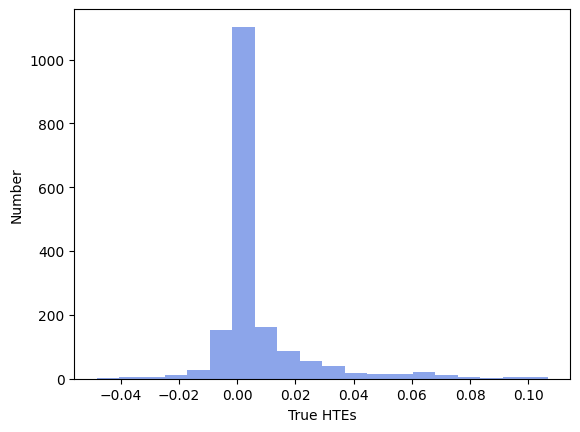

In [10]:
plt.hist(true_tao1_visit, color = '#8CA5EA' , bins=20)
plt.xlabel('True HTEs')
plt.ylabel("Number")
plt.savefig('true_ate_in_criteo.png', dpi=300, bbox_inches='tight')

In [11]:
T = 1000
N_list = [10,15,20,25,30]
cost = np.zeros((len(N_list),4,T))
decision_right_rate = np.zeros((len(N_list),2,2,T))
#N = 20
true_tao1 = deepcopy(true_tao1_visit)
pop_data = deepcopy(pop_data_visit)
weight = deepcopy(weight_visit)


K = true_tao1.shape[0]
tau_min = 0
true_tao = true_tao1 - tau_min
optimal_cost = np.sum(true_tao[np.argwhere(true_tao>0)]*weight[np.argwhere(true_tao>0)])

estimated_tau = np.zeros((len(N_list),T,K))
calculte_zeros = np.zeros((2,T))
alpha = 0.05
Z = norm.ppf( 1 - alpha/2)
for idx, N in enumerate(N_list):
    for t in tqdm(range(T)):
        #hist_data = np.zeros((K,N,2))
        tao_hat = np.zeros(K)
        variance = np.zeros(K)
        #upper_bound_list = np.zeros(K)
        p_value_list = np.ones(K)
        
        group_hist = []
        select_list = []
        for k in range(K):
            group_1 = np.array(np.random.choice(pop_data[k][0],int(N/2),replace=True))
            group_0 = np.array(np.random.choice(pop_data[k][1],N - int(N/2),replace=True))
            group_hist.append([group_1,group_0])
            
            diff_mean = group_1.mean() - group_0.mean()
            if np.std(group_1) == 0 and np.std(group_0) == 0:
                p_value = 0
            else:
                t_stat, p_value = ttest_ind(group_1, group_0, equal_var = False) 
                select_list.append(k)
                tao_hat[k] = diff_mean
                p_value_list[k] = p_value
                variance[k] = N*(group_1.var(ddof=1) / len(group_1) + group_0.var(ddof=1) / len(group_0))

        decision1 = np.intersect1d(np.argwhere(p_value_list<alpha), np.argwhere(tao_hat>tau_min))
        #decision1 = np.intersect1d(decision1,select_list)
            
        tao_0 = np.mean(tao_hat[select_list])
        numerator = np.mean(variance[select_list])
        denumerator = np.mean((tao_hat[select_list] - tao_0)**2) - numerator/N

        bayesian_tao = np.zeros(K)
        bayesian_beta = np.zeros(K)
        #p_value_list_bayesian = np.zeros(K)
        decision3 = []
        # #bayesian_variance = np.zeros(K)
        for k in select_list:
            if denumerator <= 0:
                theta = 1
                posteri_mean = tao_hat[k]*theta + (1 - theta)*tao_0
                posteri_var = 1/(N/variance[k])
                # dist = norm(loc=posteri_mean, scale=np.sqrt(posteri_var))
                # prob = dist.sf(0)  # survival function: P(X > x)
                # if prob > 1 - 0.025:
                #     decision3.append(k)
                if posteri_mean > norm.ppf(0.975)*np.sqrt(posteri_var):
                    decision3.append(k)

            else:
                bayesian_beta[k] = max(variance[k]/denumerator,0)
                theta = N/(N+bayesian_beta[k])
                posteri_mean = tao_hat[k]*theta + (1 - theta)*tao_0
                posteri_var = 1/(1/denumerator+ N/variance[k])
                # dist = norm(loc=posteri_mean, scale=np.sqrt(posteri_var))
                if posteri_mean > norm.ppf(0.975)*np.sqrt(posteri_var):
                    decision3.append(k)

                # prob = dist.sf(0)  # survival function: P(X > x)
                # if prob > 1 - 0.025:
                #     decision3.append(k)


        bayesian_tao = np.zeros(K)
        bayesian_beta = np.zeros(K)
        p_value_list_bayesian = np.ones(K)
        #bayesian_variance = np.zeros(K)
        for k in select_list:
            if tao_0 == 0 or denumerator <= 0:
                bayesian_beta[k] = 0
            else:
                bayesian_beta[k] = max(variance[k]/denumerator,0)
        decision4 = []
        for k in select_list:
            theta = N/(N+bayesian_beta[k])
            #Y_shunken = theta*Y_shunken 
            group_12 = theta*group_hist[k][0] + (1-theta)*tao_0
            group_02 = theta*group_hist[k][1]
            t_stat, p_value = ttest_ind(group_12, group_02, equal_var = False)  
            diff_mean1 = group_12.mean() - group_02.mean()
            bayesian_tao[k] = diff_mean1
            p_value_list_bayesian[k] = p_value
            if diff_mean1 > norm.ppf(0.975)*theta*np.sqrt(variance[k]/N):
                decision4.append(k)
        
        #decision4 = np.intersect1d(np.argwhere(p_value_list_bayesian<alpha), np.argwhere(bayesian_tao>tau_min))
        

        if tao_0 == 0 or denumerator == 0:
            beta = 0
        else:
            beta = numerator/denumerator + Z*np.sqrt(N*numerator)/tao_0
        
        beta = max(0,beta)
        #print(beta)
        theta = N/(N+beta)
        tao_shunken_hat = np.zeros(K)
        p_value_list_shrunken = np.ones(K)

        for k in select_list:
            group_11 = theta*group_hist[k][0] + (1-theta)*tao_0
            group_00 = theta*group_hist[k][1]
            if np.std(group_11) == 0 and np.std(group_00) == 0:
                p_value = 0
            else:
                t_stat, p_value = ttest_ind(group_11, group_00, equal_var = False)

            diff_mean1 = group_11.mean() - group_00.mean()
            tao_shunken_hat[k] = diff_mean1
            p_value_list_shrunken[k] = p_value
        decision2 = np.intersect1d(np.argwhere(p_value_list_shrunken<alpha), np.argwhere(tao_shunken_hat>tau_min))
      
        cost[idx,0,t] = np.sum(true_tao[decision1]*weight[decision1])/optimal_cost
        cost[idx,1,t] = np.sum(true_tao[decision2]*weight[decision2])/optimal_cost
        cost[idx,2,t] = np.sum(true_tao[decision3]*weight[decision3])/optimal_cost
        cost[idx,3,t] = np.sum(true_tao[decision4]*weight[decision4])/optimal_cost

        negative_right1 = 0
        negative_right2 = 0
        positive_right1 = 0
        positive_right2 = 0
        for k in range(K):
            if true_tao[k] < 0 and k not in decision1:
                negative_right1 += 1
            if true_tao[k] < 0 and k not in decision2:
                negative_right2 += 1
            if true_tao[k] > 0 and k in decision1:
                positive_right1 += 1
            if true_tao[k] > 0 and k in decision2:
                positive_right2 += 1

        decision_right_rate[idx,0,0,t] = positive_right1/(len(np.argwhere(true_tao>0)))
        decision_right_rate[idx,1,0,t] = positive_right2/(len(np.argwhere(true_tao>0)))
        decision_right_rate[idx,0,1,t] = negative_right1/(len(np.argwhere(true_tao<0)))
        decision_right_rate[idx,1,1,t] = negative_right2/(len(np.argwhere(true_tao<0)))

  0%|          | 0/1000 [00:00<?, ?it/s]/Users/xubo/anaconda3/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
100%|██████████| 1000/1000 [32:23<00:00,  1.94s/it]


In [ ]:
for k in select_list:
    theta = N/(N+bayesian_beta[k])
    #Y_shunken = theta*Y_shunken 
    group_12 = theta*group_hist[k][0] + (1-theta)*tao_0
    group_02 = theta*group_hist[k][1]
    t_stat, p_value = ttest_ind(group_12, group_02, equal_var = False)  
    diff_mean1 = group_12.mean() - group_02.mean()
    bayesian_tao[k] = diff_mean1
    p_value_list_bayesian[k] = p_value

In [41]:
bayesian_tao[13],p_value_list_bayesian[13],p_value_list[13]

(0.07193114198857545, 0.009829133371725966, 0.373900966300059)

In [33]:
p_value_list_bayesian[13]
theta = N/(N+bayesian_beta[13])

In [46]:
for k in select_list:
    if denumerator <= 0:
        theta = 1
        posteri_mean = tao_hat[k]*theta + (1 - theta)*tao_0
        posteri_var = 1/(N/variance[k])
        dist = norm(loc=posteri_mean, scale=np.sqrt(posteri_var))
        prob = dist.sf(0)  # survival function: P(X > x)
        if prob > 1 - 0.025:
            decision3.append(k)
    else:
        bayesian_beta[k] = max(variance[k]/denumerator,0)
        theta = N/(N+bayesian_beta[k])
        posteri_mean = tao_hat[k]*theta + (1 - theta)*tao_0
        posteri_var = 1/(1/denumerator+ N/variance[k])
        dist = norm(loc=posteri_mean, scale=np.sqrt(posteri_var))

        

        prob = dist.sf(0)  # survival function: P(X > x)
        if k == 231:
            print(theta)
            print(prob)
            print(posteri_mean,tao_hat[k],tao_0)
            print(posteri_var)
        
        if prob > 1 - 0.025:
            decision3.append(k)

0.08866644110130868
0.9691087734442296
0.11123783116157873 0.8 0.044226044226044224
0.003546657644052348


In [48]:
decision1

array([1647])

In [24]:
tao_0

0.020768431983385256

In [55]:
decision3

[]

In [56]:
decision4

[200,
 202,
 226,
 242,
 255,
 281,
 287,
 288,
 298,
 330,
 341,
 391,
 394,
 606,
 611,
 636,
 684,
 701,
 702,
 706,
 724,
 732,
 734,
 773,
 799,
 800,
 801,
 1112,
 1130,
 1197,
 1203,
 1214,
 1229,
 1237,
 1246,
 1251,
 1262,
 1277,
 1558,
 1584,
 1596,
 1611,
 1634,
 1656,
 1688,
 1698,
 1721,
 1730,
 1745]

In [16]:
np.sum(true_tao)/np.sum(true_tao[np.argwhere(true_tao>0)])

0.924295232187387

In [19]:
np.mean(cost,axis=2)

array([[0.00573663, 0.3455235 , 0.03268711, 0.24273418],
       [0.01633617, 0.44063868, 0.04192331, 0.33951808],
       [0.03074977, 0.51053695, 0.05220758, 0.41441043],
       [0.0364814 , 0.56594044, 0.03966734, 0.48417405],
       [0.05452245, 0.60429938, 0.0535985 , 0.52571139]])

In [14]:
np.mean(cost,axis=2)[:,1]

array([0.32519912, 0.45210789, 0.50625609, 0.0428305 , 0.        ])

In [15]:
np.mean(cost,axis=2)[:,2]

array([0.0346188 , 0.0322727 , 0.04575955, 0.00317244, 0.        ])

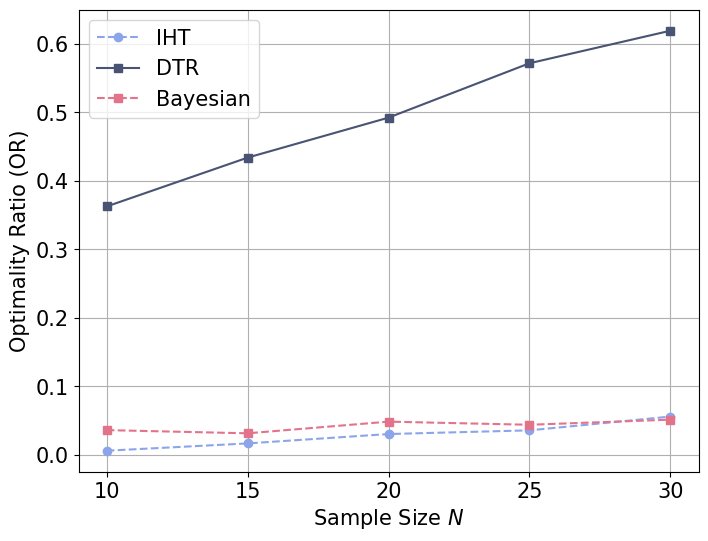

In [12]:
plt.figure(figsize=(8,6))
plt.xlabel(r'Sample Size $N$',fontsize=15)
plt.ylabel('Optimality Ratio (OR)',fontsize=15)
x = N_list

y3 = np.mean(cost,axis=2)[:,0]
plt.plot(x, y3, color = '#8CA5EA',linestyle = '--', marker='o',label = "IHT")

y3 = np.mean(cost,axis=2)[:,1]
plt.plot(x, y3, color = '#495373',marker = "s",label = "DTR")

y3 = np.mean(cost,axis=2)[:,2]
plt.plot(x, y3, color = '#E3738B',marker = "s",label = "Bayesian",linestyle = '--')

plt.xticks(x,fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.grid()
plt.savefig('real_data_OR_compare_criteo_with_beyesian.png',dpi=300,bbox_inches = 'tight')
plt.show()

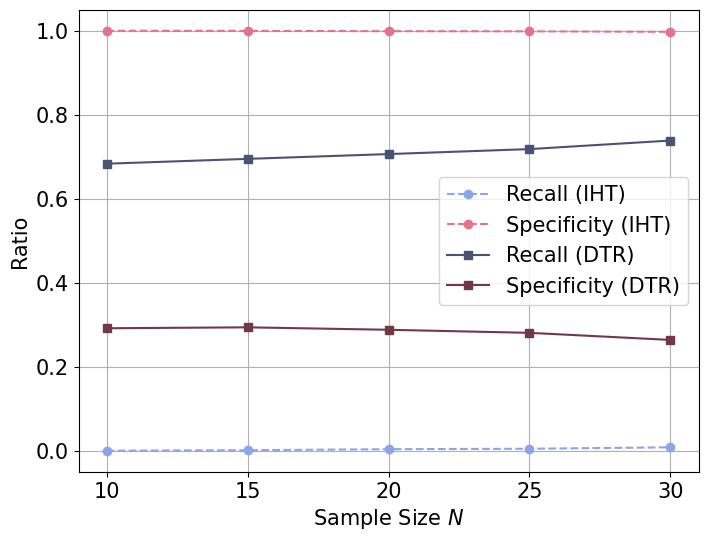

In [15]:
plt.figure(figsize=(8,6))
plt.xlabel(r'Sample Size $N$',fontsize=15)
plt.ylabel('Ratio',fontsize=15)
x = [10,15,20,25,30]

y_positve = np.mean(decision_right_rate[:,0,:,:],axis=2)[:,0]
y_negative = np.mean(decision_right_rate[:,0,:,:],axis=2)[:,1]
plt.plot(x, y_positve, color = '#8CA5EA',linestyle = '--', marker='o',label = "Recall (IHT)")
plt.plot(x, y_negative, color = '#E3738B',linestyle = '--', marker='o',label = "Specificity (IHT)")

y_positve = np.mean(decision_right_rate[:,1,:,:],axis=2)[:,0]
y_negative = np.mean(decision_right_rate[:,1,:,:],axis=2)[:,1]
plt.plot(x, y_positve, color = '#495373', marker='s',label = "Recall (DTR)")
plt.plot(x, y_negative, color = '#713948', marker='s',label = "Specificity (DTR)")

plt.xticks(x,fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.grid()
plt.savefig('right_decision_criteo.png',dpi=300,bbox_inches = 'tight')
plt.show()

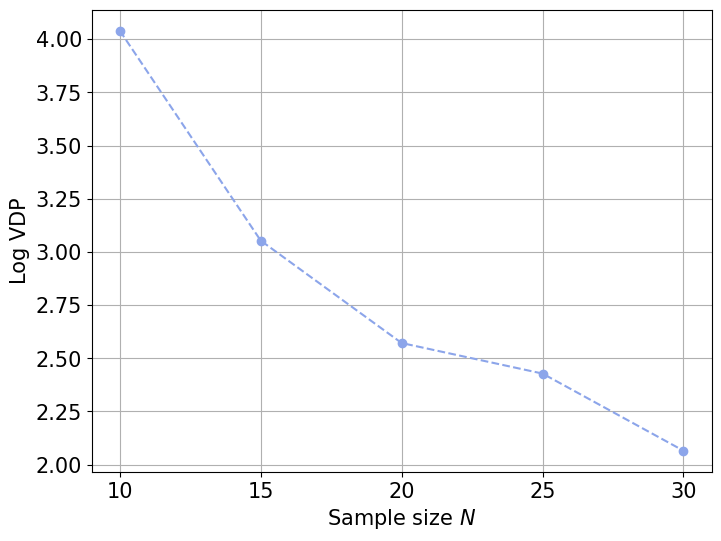

In [16]:
x = [10,15,20,25,30]
y1 =  np.mean(cost,axis=2)[:,0]
y2 = np.mean(cost,axis=2)[:,1]
plt.figure(figsize=(8,6))
plt.xlabel(r'Sample size $N$',fontsize=15)
plt.ylabel('Log VDP',fontsize=15)

plt.plot(x, [np.log(y2[i]/y1[i] - 1) for i in range(5)], color = '#8CA5EA',linestyle = '--', marker='o')

plt.xticks(x,fontsize=15)
plt.yticks(fontsize=15)
plt.grid()
plt.savefig('real_data_VDP_compare_with_N_criteo.png',dpi=300,bbox_inches = 'tight')
plt.show()